# Analysis of Experiment 2 (Neuroscience)
In this notebook I will walk through the analysis I did for the second Experiment. There are 4 major sections:
* Preperation and First Look
* Good vs Bad Explanations Overall
* The Conditions
* Neuro Science Language in the Response

## Preperation and First Look

In [1]:
#Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from utils_openAI import *

In [5]:
#read data
df = pd.read_csv('NeuroExp2_Pilot.csv')
df.shape
df.head()

,Unnamed: 0,stimulus_number,condition,good_first,answer
0,0,2,With,True,[1]-I choose explanation 1 because it provides...
1,0,1,Without,False,[2]-I chose explanation 2 because it seems mor...
2,0,2,With,True,[1]-I choose explanation 1 because it provides...
3,0,1,Mixed,True,[2]-I chose explanation 2 because it provides ...
4,0,1,With,True,[2]-I chose explanation 2 because it provides ...


In [3]:
#get the value count of the different conditions
print(df['condition'].value_counts())
#get value counts of stimulous
print(df['stimulus_number'].value_counts())
#get value counts of answer good
print(df['good_first'].value_counts())

With       12
Without    10
Mixed       8
Name: condition, dtype: int64
1    14
2     9
0     7
Name: stimulus_number, dtype: int64
True     21
False     9
Name: good_first, dtype: int64


Looks good so far. Next, let's clean the data. 

In [17]:
#only keep columns of interest
df = df[['stimulus_number', 'condition', 'answer', 'good_first']]
df['rating'] = df['answer'].str.split('-').str[0] #split at - and take first part as number
df['rating'] = [re.sub("[^0-9-+]", "", df['rating'][i]) for i in range(len(df))] #keep number only
df['rating'] = df['rating'].astype(int) #turn to int
df['explanation_choice'] = df['answer'].str.split('-').str[1] #split at - and take second part as explanation choice
#turn good first numeric
df['good_first_int'] = df['good_first'].astype(int)
#create nueric version of condition
df['condition_num'] = df['condition'].replace({'With': 1, 'Without': 0, 'Mixed': 2})
#create variable indicating whether good condition was picked. It is True if the rating is 1 and good_first is true, or if the rating is 2 and good_first is false, otherwise good_condition is false
df['good_choice'] = np.where((df['rating'] == 1) & (df['good_first_int'] == 1), True, np.where((df['rating'] == 2) & (df['good_first_int'] == 0), True, False))
df['good_choice_int'] = df['good_choice'].astype(int) #turn into numeric as well
#create one hot encoded version of condition
df_ohe = pd.get_dummies(df, columns = ['condition']) #One hot encode conditions in seperate df
df_ohe = pd.get_dummies(df_ohe, columns = ['stimulus_number']) #One hot encode stimulus in seperate df
df_ohe.head()



,answer,good_first,rating,explanation_choice,good_first_int,condition_num,good_choice,good_choice_int,condition_Mixed,condition_With,condition_Without,stimulus_number_0,stimulus_number_1,stimulus_number_2
0,[1]-I choose explanation 1 because it provides...,True,1,I choose explanation 1 because it provides a p...,1,1,True,1,0,1,0,0,0,1
1,[2]-I chose explanation 2 because it seems mor...,False,2,I chose explanation 2 because it seems more pl...,0,0,True,1,0,0,1,0,1,0
2,[1]-I choose explanation 1 because it provides...,True,1,I choose explanation 1 because it provides a c...,1,1,True,1,0,1,0,0,0,1
3,[2]-I chose explanation 2 because it provides ...,True,2,I chose explanation 2 because it provides a mo...,1,2,False,0,1,0,0,0,1,0
4,[2]-I chose explanation 2 because it provides ...,True,2,I chose explanation 2 because it provides a cl...,1,1,False,0,0,1,0,0,1,0


## Good vs Bad Explanations Overall
The first step is to see if there is a difference generally between picking good and bad explanations.

In [11]:
#get the proportion of choosing the good explanation overall
df['good_choice_int'].mean()

0.7333333333333333

([<matplotlib.patches.Wedge at 0x7ff43a88e550>,
 [Text(-0.7360437078139774, 0.8174592712713291, 'Good'),
  Text(0.7360437843500347, -0.8174592023579401, 'Bad')],
 [Text(-0.4014783860803513, 0.44588687523890674, '73.3%'),
  Text(0.4014784278272916, -0.4458868376497855, '26.7%')])

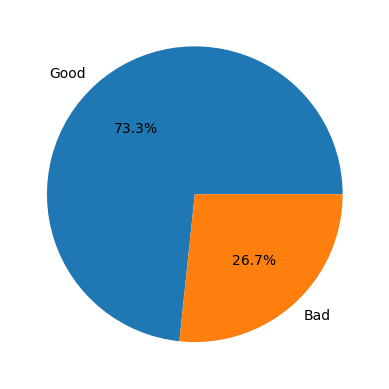

In [13]:
#make a pie graph of the choice of good and bad explantion
plt.pie(df['good_choice_int'].value_counts(), labels = ['Good', 'Bad'], autopct='%1.1f%%')

In [12]:
#test whether the good explanation was chosen more often than chance level
ttest_ind(df['good_choice_int'], [0.5]*len(df))

/var/folders/dv/nfxpqfgn50ncwmnyg61n91m80000gn/T/ipykernel_34700/3377329010.py:2: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest_ind(df['good_choice_int'], [0.5]*len(df))


Ttest_indResult(statistic=2.8414544931009598, pvalue=0.006187121107816287)

In [54]:
#run a logistic regression with condition as predictor and whether the participant picked the good answer as outcome, also add whether they saw the good explanation first as predictor
logit_model = sm.Logit(df_ohe['good_choice_int'], sm.add_constant(df_ohe[['condition_With', 'condition_Without', 'stimulus_number_0', 'stimulus_number_1', 'good_first_int']])) #reference: Mixed and stim 2
#without int: logit_model = sm.Logit(df_ohe['good_choice_int'], df_ohe[['condition_With', 'condition_Without', 'stimulus_number_0', 'stimulus_number_1', 'good_first_int']]) #reference: Mixed and stim 2


result = logit_model.fit()
print(result.summary2())

PerfectSeparationError: Perfect separation detected, results not available

## The Conditions
Here I compare the proportions of choosing the good or bad explanations per condition.

In [19]:
#compare three proportions of choosing the good explanation
prop_with = df[df['condition'] == 'With']['good_choice_int'].mean()
prop_without = df[df['condition'] == 'Without']['good_choice_int'].mean()
prop_mixed = df[df['condition'] == 'Mixed']['good_choice_int'].mean()
print(prop_with, prop_without, prop_mixed)

0.6666666666666666 1.0 0.5


Text(1, 1.05, '1.0')

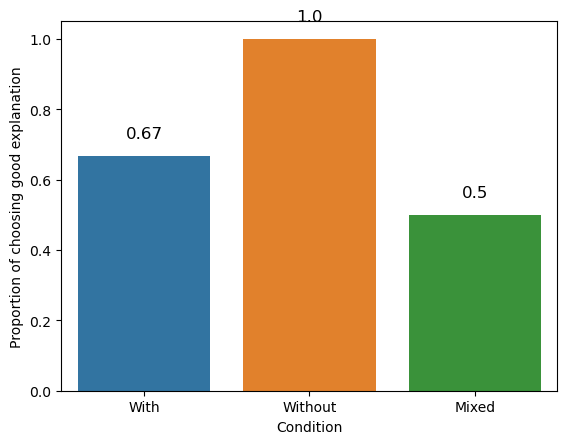

In [34]:
#make three plots
sns.barplot(x = 'condition', y = 'good_choice_int', data = df, ci= None)
#add x and y axis labels
plt.xlabel('Condition')
plt.ylabel('Proportion of choosing good explanation')
#add numeric values to top of bar
plt.text(x = 0, y = df[df['condition_num'] == 1]['good_choice_int'].mean() + 0.05, s = round(df[df['condition_num'] == 1]['good_choice_int'].mean(), 2), size = 12, ha = 'center')
plt.text(x = 2, y = df[df['condition_num'] == 2]['good_choice_int'].mean() + 0.05, s = round(df[df['condition_num'] == 2]['good_choice_int'].mean(), 2), size = 12, ha = 'center')
plt.text(x = 1, y = df[df['condition_num'] == 0]['good_choice_int'].mean() + 0.05, s = round(df[df['condition_num'] == 0]['good_choice_int'].mean(), 2), size = 12, ha = 'center')

In [51]:
#compare proportions 
#non-parametric (Chi-square)
from scipy.stats import chi2_contingency
#make contingency table
contingency_table = pd.crosstab(df['condition'], df['good_choice_int'])
#do chi-square test
c, p, dof, expected = chi2_contingency(contingency_table) 

print('-----Overall-----')
print("Chi-square statistic:", c)
print("DF:", dof)
print("p-value:", p)

#do the same with with vs without
df_subset = df[df['condition'] != 'Mixed']
contingency_table = pd.crosstab(df_subset['condition'], df_subset['good_choice_int'])
#do chi-square test
c, p, dof, expected = chi2_contingency(contingency_table) 

print('-----With vs Without-----')
print("Chi-square statistic:", c)
print("DF:", dof)
print("p-value:", p)

#do the same with with vs mixed
df_subset = df[df['condition'] != 'Without']
contingency_table = pd.crosstab(df_subset['condition'], df_subset['good_choice_int'])
#do chi-square test
c, p, dof, expected = chi2_contingency(contingency_table) 

print('-----With vs Mixed-----')
print("Chi-square statistic:", c)
print("DF:", dof)
print("p-value:", p)

#do the same with Mixed vs without
df_subset = df[df['condition'] != 'With']
contingency_table = pd.crosstab(df_subset['condition'], df_subset['good_choice_int'])
#do chi-square test
c, p, dof, expected = chi2_contingency(contingency_table) 

print('-----Mixed vs Without-----')
print("Chi-square statistic:", c)
print("DF:", dof)
print("p-value:", p)





-----Overall-----
Chi-square statistic: 6.136363636363636
DF: 2
p-value: 0.046505633732877326
-----With vs Without-----
Chi-square statistic: 2.1414351851851854
DF: 1
p-value: 0.14336771150104505
-----With vs Mixed-----
Chi-square statistic: 0.0781249999999999
DF: 1
p-value: 0.7798546179649193
-----Mixed vs Without-----
Chi-square statistic: 3.861160714285715
DF: 1
p-value: 0.049416130831850584


Potential Issue with One way anova: 
A one-way ANOVA may not be the best statistical test to use for comparing proportions between three conditions because ANOVA assumes that the data is normally distributed and continuous. Proportions, on the other hand, are discrete data and have a specific range of values between 0 and 1.

Instead, use chi-square test of independence, and kruskal wallis test to locate the difference if the chi-square test is significant. This is more appropriate than the fishers test for large sample sizes, which we have. 

## Neuro Science Language in the Response

In [55]:
df_subset = df[df['condition'] != 'Without'] #create subset of with and mixed condition
#create a variable that is 1 if the explanation_choice contains one of the following words: “brain”, “lobe,”, “scan”, “neur*”, “premotor,” “cortex”
df_subset['neuro_used'] = np.where(df_subset['explanation_choice'].str.contains('brain|lobe|scan|neur|premotor|cortex'), 1, 0)

/var/folders/dv/nfxpqfgn50ncwmnyg61n91m80000gn/T/ipykernel_34700/1715165750.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['neuro_used'] = np.where(df_subset['explanation_choice'].str.contains('brain|lobe|scan|neur|premotor|cortex'), 1, 0)


In [58]:
#proportion that contains these words
print('----Overall----')
print(df_subset['neuro_used'].mean())
#proportion that contains these words in each condition
print('----By condition----')
print(df_subset.groupby('condition')['neuro_used'].mean())
#proportion that contains these words in for answer good or not
print('----By choosing good answer----')
print(df_subset.groupby('good_choice_int')['neuro_used'].mean())
#proportion by condition and answer
print('----By condition and choosing good answer----')
print(df_subset.groupby(['condition', 'good_choice_int'])['neuro_used'].mean())

----Overall----
0.55
----By condition----
condition
Mixed    0.750000
With     0.416667
Name: neuro_used, dtype: float64
----By choosing good answer----
good_choice_int
0    0.500000
1    0.583333
Name: neuro_used, dtype: float64
----By condition and choosing good answer----
condition  good_choice_int
Mixed      0                  1.000
           1                  0.500
With       0                  0.000
           1                  0.625
Name: neuro_used, dtype: float64
